In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-454'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key_train = 'Project_1/dmc2010_train.txt'
file_key_test = 'Project_1/dmc2010_class.txt'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading train file
train = pd.read_csv(file_content_stream_train, sep = ';')
train.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,...,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
0,41191,2008-12-01,0,0,9,2008-12-01,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
1,38860,2008-12-16,1,0,4,2008-12-16,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,61917,2008-08-19,0,0,12,2008-08-19,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,40647,2008-06-16,1,0,8,2008-06-16,0,1,0,0,...,0,0,0,2,0,0,0,0,0,0
4,1347,2008-08-08,0,0,1,2008-08-08,0,1,1,1,...,2,0,0,0,0,0,0,0,0,0


In [2]:
## Reading train file
test = pd.read_csv(file_content_stream_test, sep = ';')
test.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customernumber,date,salutation,title,domain,datecreated,newsletter,model,paymenttype,deliverytype,...,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10
0,6044,2008-07-02,2,0,12,2008-07-02,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1,36314,2008-09-09,1,0,4,2008-09-09,0,3,1,1,...,0,0,0,0,0,0,0,0,0,0
2,41932,2008-10-11,0,0,5,2008-10-11,1,1,2,0,...,0,0,0,0,1,0,0,0,0,0
3,3194,2008-09-15,2,0,12,2008-09-15,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,35363,2008-04-02,0,0,0,2008-04-02,0,1,3,0,...,1,0,0,0,0,0,0,0,1,0


## Initial Data Exploration

### Buys by Salutation

In [15]:
## Creating table of buys based on gender
gender_buys = pd.DataFrame(pd.crosstab(train['salutation'], train['target90']))
gender_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
gender_buys['Row_Tot'] = gender_buys['No_Buy'] + gender_buys['Buy']

## Computing buys percentages
gender_buys['Buy_pct'] = gender_buys['Buy'] / gender_buys['Row_Tot']
gender_buys.head()

,No_Buy,Buy,Row_Tot,Buy_pct
salutation,,,,
0,14391,3449,17840,0.193330
1,9454,2160,11614,0.185982
2,2532,442,2974,0.148621


### Buys by domain

In [16]:
## Creating table of buys based on domain
domain_buys = pd.DataFrame(pd.crosstab(train['domain'], train['target90']))
domain_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
domain_buys['Row_Tot'] = domain_buys['No_Buy'] + domain_buys['Buy']

## Computing buys percentages
domain_buys['Buy_pct'] = domain_buys['Buy'] / domain_buys['Row_Tot']
domain_buys

,No_Buy,Buy,Row_Tot,Buy_pct
domain,,,,
0,971,202,1173,0.172208
1,912,227,1139,0.199298
2,991,205,1196,0.171405
3,323,58,381,0.152231
4,5430,1197,6627,0.180625
5,1062,249,1311,0.189931
6,438,110,548,0.200730
7,93,20,113,0.176991
8,2951,743,3694,0.201137


### Buys by voucher

In [17]:
## Creating table of buys based on domain
voucher_buys = pd.DataFrame(pd.crosstab(train['voucher'], train['target90']))
voucher_buys.columns = ['No_Buy', 'Buy']

## Computing row totals
voucher_buys['Row_Tot'] = voucher_buys['No_Buy'] + voucher_buys['Buy']

## Computing buys percentages
voucher_buys['Buy_pct'] = voucher_buys['Buy'] / voucher_buys['Row_Tot']
voucher_buys

,No_Buy,Buy,Row_Tot,Buy_pct
voucher,,,,
0,21967,5207,27174,0.191617
1,4410,844,5254,0.160640


### Buys by 

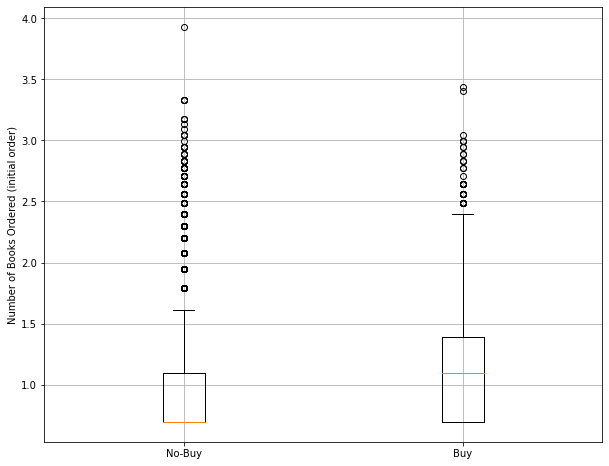

In [28]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
target0 = train[train['target90'] == 0]
target1 = train[train['target90'] == 1]

## Creating side-by-side box plots
plt.boxplot([np.log(target0['numberitems'] + 1), np.log(target1['numberitems'] + 1)], labels = ['No-Buy', 'Buy'])
plt.ylabel('Number of Books Ordered (initial order)')
plt.grid()

## saving the plot
# plt.savefig('side_by_side_boxplot.pdf')

plt.show()

In [3]:
pd.crosstab(train['salutation'], train['target90'])

target90,0,1
salutation,,
0,14391,3449
1,9454,2160
2,2532,442


In [ ]:
pd.crosstab(train['salutation'], train['target90'])

In [11]:
train.shape

(32428, 38)

In [107]:
train['w10'].value_counts()

0     30489
1      1451
2       288
3       102
4        38
5        20
6        13
7        10
8         3
10        3
9         2
15        2
38        1
13        1
20        1
50        1
27        1
17        1
12        1
Name: w10, dtype: int64

In [112]:
x = train[train['w10'] == 4]
X = pd.DataFrame(pd.crosstab(x['salutation'], x['target90']))
X.columns = ['No_Buy', 'Buy']

X['Row_Tot'] = X['No_Buy'] + X['Buy']
X['Buy_pct'] = X['Buy'] / X['Row_Tot']
X

,No_Buy,Buy,Row_Tot,Buy_pct
salutation,,,,
0,21,7,28,0.250000
1,6,1,7,0.142857
2,3,0,3,0.000000


In [119]:
Y = pd.crosstab(train['newsletter'], train['target90']) 
Y.columns = ['No_Buy', 'Buy']

Y['Row_Tot'] = Y['No_Buy'] + Y['Buy']
Y['Buy_pct'] = Y['Buy'] / Y['Row_Tot']
Y

,No_Buy,Buy,Row_Tot,Buy_pct
newsletter,,,,
0,22300,4632,26932,0.171989
1,4077,1419,5496,0.258188
